In [41]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
import numpy as np

In [2]:
trainPath = r'dataset\train.csv'
testPath = r'dataset\test.csv'

In [3]:
trainData = pd.read_csv(trainPath)
trainData

,ID,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,recycles_regularly,composts_organic_waste,uses_solar_panels,energy_efficient_appliances,heating_type,diet_type,owns_pet,smart_thermostat_installed,carbon_footprint
0,0xd6c,759.70,55.95,944.55,2422.07,541.27,1,3,2,4.23,9,1.0,0.0,0,1.0,gas,vegetarian,1,NaN,830.10
1,0x3fdf,387.06,70.59,1280.85,1995.3,280.39,1,2,1,3.27,8,0.0,0.0,0,0.0,electric,vegetarian,0,0.0,963.08
2,0x3b08,594.25,29.14,1005.72,2673.55,416.14,0,2,3,2.87,3,0.0,1.0,0,1.0,electric,omnivore,1,1.0,840.11
3,0x31e5,503.76,74.68,1049.46,2994.28,530.13,0,5,1,3.22,9,1.0,0.0,0,0.0,electric,omnivore,1,0.0,1252.42
4,0x397e,549.54,-77.00,756.49,2549.57,604.10,5,4,4,2.92,2,1.0,0.0,0,1.0,electric,vegetarian,0,1.0,580.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0x4aaa,324.96,43.37,438.36,1514.05,419.48,3,1,2,3.17,7,0.0,0.0,0,0.0,electric,omnivore,1,1.0,865.07
13996,0x36c3,581.19,83.50,1865.29,3357.9,651.11,0,1,3,6.60,3,1.0,1.0,0,0.0,gas,omnivore,1,0.0,1594.70
13997,0x3846,302.76,43.36,212.42,939.08,343.67,9,1,2,3.07,3,1.0,0.0,1,0.0,gas,omnivore,1,1.0,712.94
13998,0x4ba4,397.77,14.80,592.66,1164.04,271.67,2,7,0,2.48,4,1.0,0.0,1,0.0,gas,vegetarian,0,0.0,533.65


## **EDA**

In [4]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14000 non-null  object 
 1   electricity_kwh_per_month        14000 non-null  float64
 2   natural_gas_therms_per_month     14000 non-null  float64
 3   vehicle_miles_per_month          14000 non-null  float64
 4   house_area_sqft                  14000 non-null  object 
 5   water_usage_liters_per_day       14000 non-null  float64
 6   public_transport_usage_per_week  14000 non-null  int64  
 7   household_size                   14000 non-null  object 
 8   home_insulation_quality          14000 non-null  int64  
 9   meat_consumption_kg_per_week     14000 non-null  float64
 10  laundry_loads_per_week           14000 non-null  int64  
 11  recycles_regularly               13590 non-null  float64
 12  composts_organic_w

In [5]:
trainData.energy_efficient_appliances.unique()

array([ 1.,  0., nan])

In [6]:
trainData.owns_pet.unique()

array([1, 0])

In [7]:
trainData.carbon_footprint.min()

np.float64(310.0)

In [8]:
def outliers(df : pd.DataFrame, column_name : str):
    df_in = df.copy()

    Q1 = df_in[column_name].quantile(0.25)
    Q3 = df_in[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_in[(df_in[column_name] < lower_bound) |
                    (df_in[column_name] > upper_bound)]
    
    plt.figure(figsize=(20, 5))
    plt.boxplot(trainData[column_name] , vert=False)
    plt.show()

    print("Outliers:")
    print(outliers[[column_name]])

    return upper_bound, lower_bound


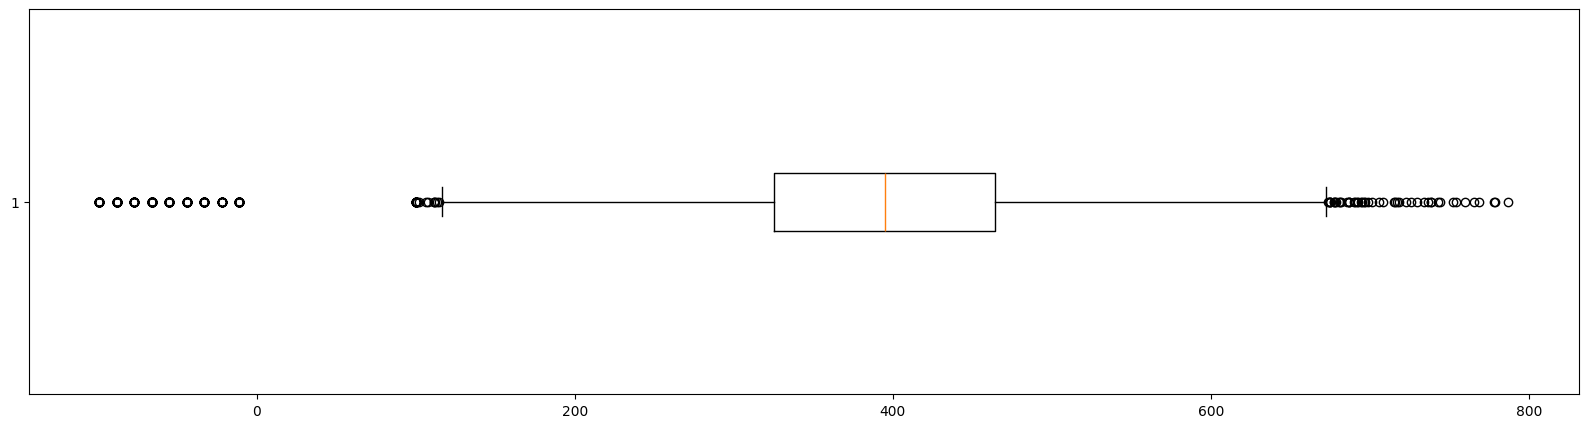

Outliers:
       electricity_kwh_per_month
0                         759.70
40                        -55.00
69                        -88.00
94                        -33.00
126                       -77.00
...                          ...
13853                     -77.00
13876                     -99.00
13977                     -11.00
13983                     696.77
13987                     -77.00

[369 rows x 1 columns]


In [9]:
upper_bound_elec, lower_bound_elec = outliers(trainData, 'electricity_kwh_per_month')

A important question arises here that is should we remove these outliers, since electricity usage can vary from house to house and high usage may not neccesarily be outliers but just characterstic of the data.

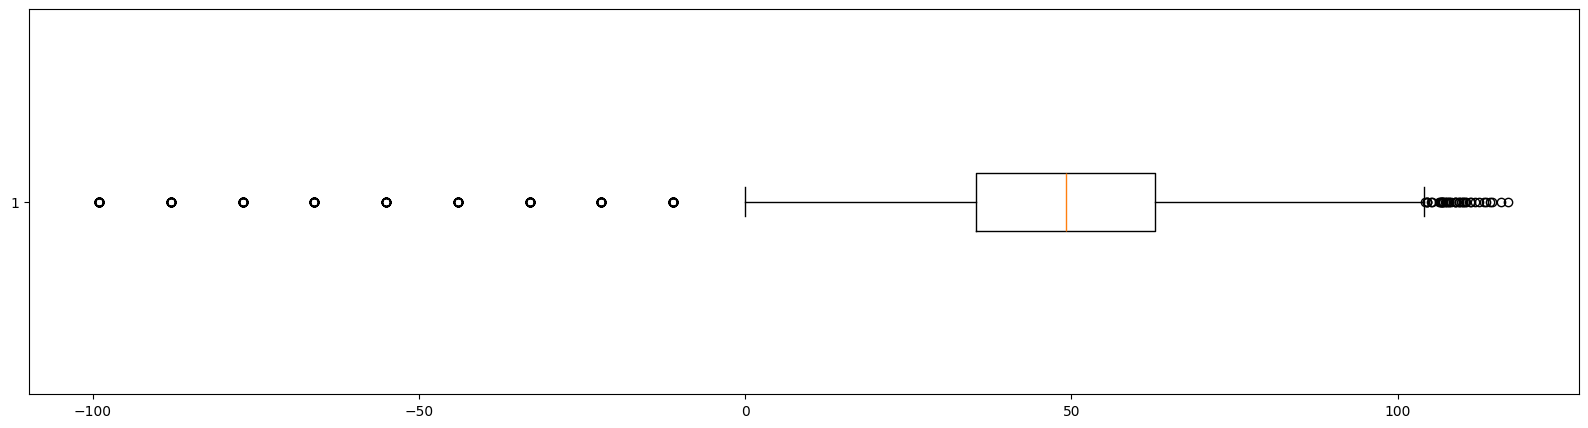

Outliers:
       natural_gas_therms_per_month
4                            -77.00
72                           -11.00
104                          -33.00
131                          -66.00
152                          -33.00
...                             ...
13893                        104.45
13907                        107.29
13922                        -77.00
13952                        -44.00
13954                        -99.00

[331 rows x 1 columns]


In [10]:
upper_bound_gas, lower_bound_gas = outliers(trainData, 'natural_gas_therms_per_month')

In [11]:
trainData.natural_gas_therms_per_month = trainData.natural_gas_therms_per_month.clip(lower=0)

A point could be made here also, but gas usage can't be a negative value.

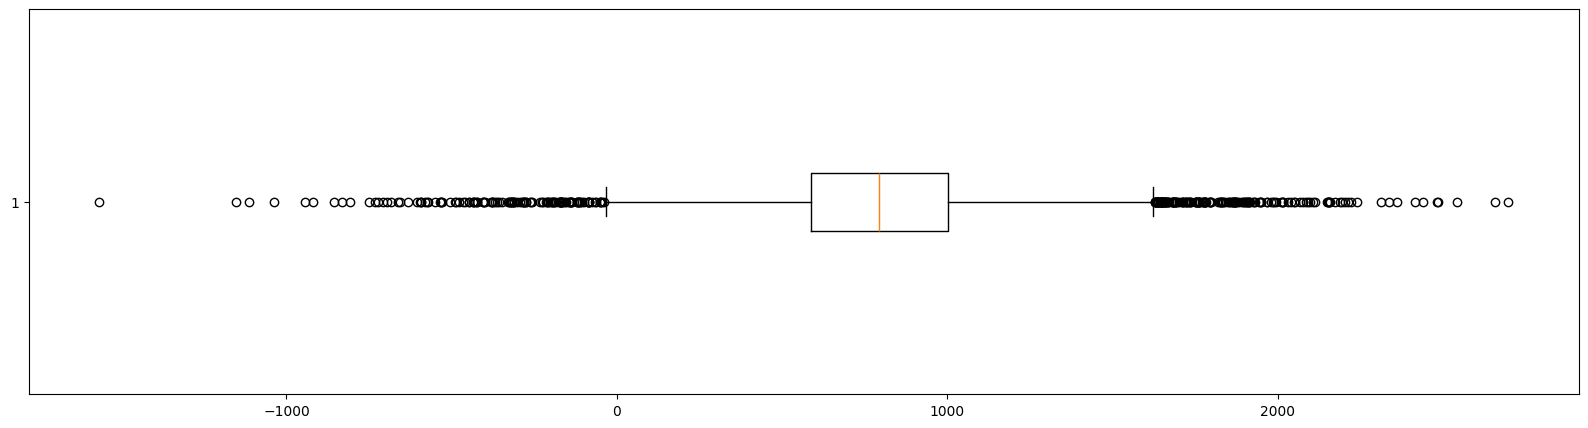

Outliers:
       vehicle_miles_per_month
17                 1645.640000
55                 -209.101901
66                 1794.484160
118                2155.209928
154                1876.046083
...                        ...
13812              1883.763297
13900              -213.728563
13911              1872.494028
13959              -662.695119
13996              1865.290000

[312 rows x 1 columns]


In [12]:
upper_bound_gas, lower_bound_gas = outliers(trainData, 'vehicle_miles_per_month')

In [13]:
trainData.vehicle_miles_per_month = trainData.vehicle_miles_per_month.clip(lower=0)

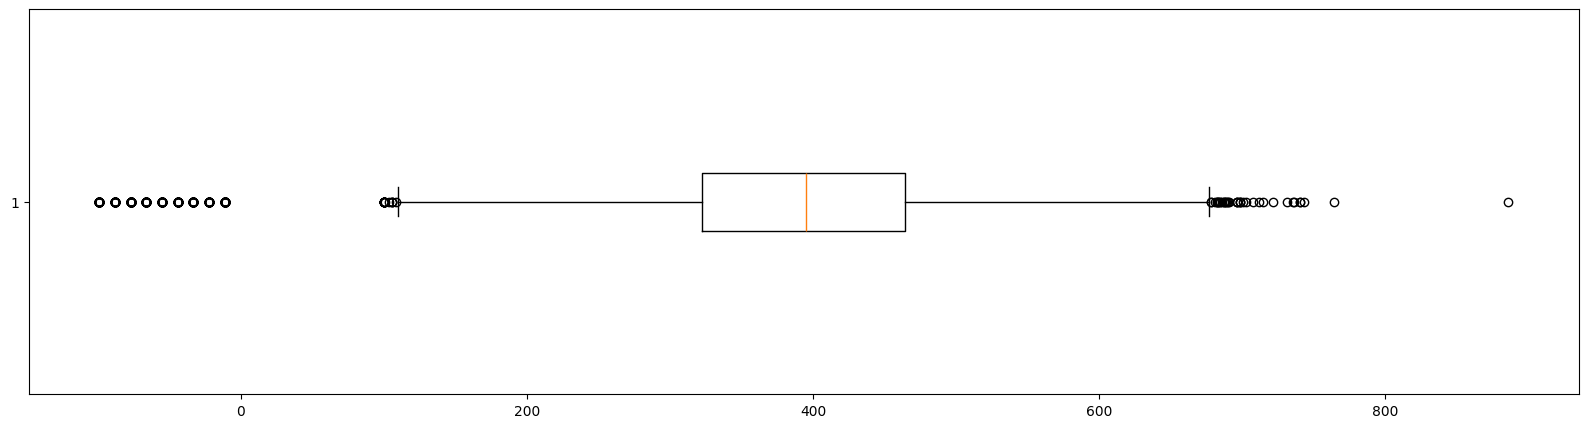

Outliers:
       water_usage_liters_per_day
12                         -55.00
50                         -66.00
51                         -88.00
74                         -11.00
84                         -55.00
...                           ...
13901                      -44.00
13915                      -88.00
13959                      -33.00
13975                      690.41
13991                      103.49

[488 rows x 1 columns]


In [14]:
upper_bound_water, lower_bound_water = outliers(trainData, 'water_usage_liters_per_day')

In [15]:
trainData.water_usage_liters_per_day = trainData.water_usage_liters_per_day.abs()

Can't be living without water

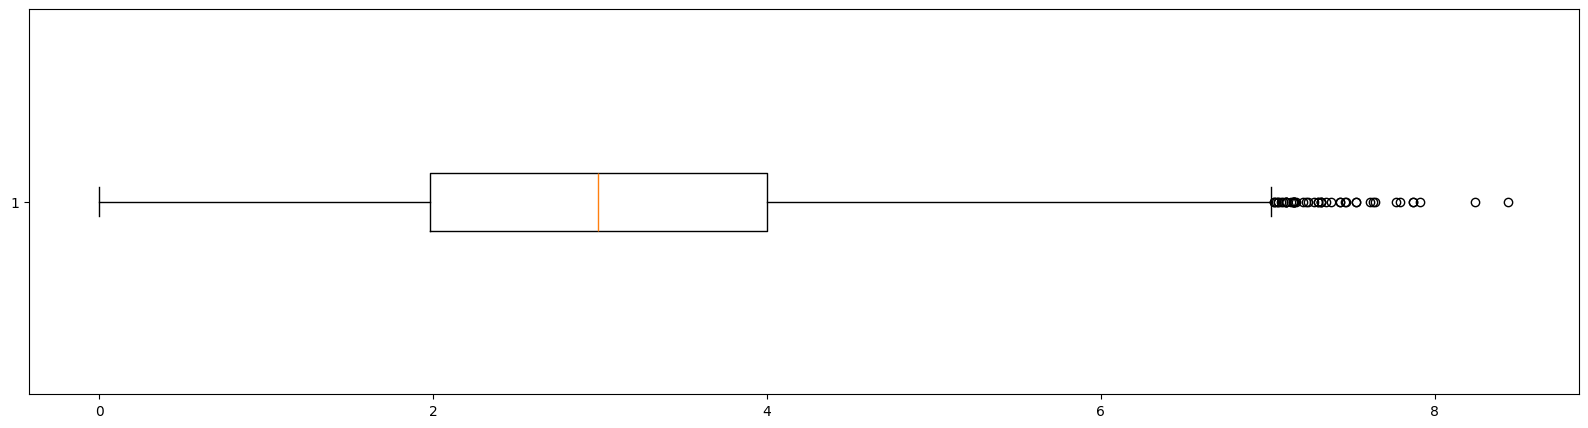

Outliers:
       meat_consumption_kg_per_week
276                            7.04
364                            7.87
784                            7.46
806                            7.06
1302                           7.43
1390                           7.15
2128                           7.05
2365                           7.14
2517                           7.30
2581                           7.11
2596                           7.43
2759                           8.24
3151                           7.32
3300                           7.32
4060                           7.16
4092                           7.17
4438                           7.53
4673                           7.79
4722                           7.38
4754                           7.47
4771                           7.53
5272                           7.91
5661                           7.11
5929                           7.87
6103                           7.28
6125                           7.23
6147              

In [16]:
upper_bound_meat, lower_bound_meat = outliers(trainData, 'meat_consumption_kg_per_week')

Could be due to more Members in the household

In [17]:
def draw_pie(series: pd.Series, figsize: tuple = (7.5, 7.5), title : str = None, ax=None):
    values = series.value_counts()
    labels = values.index
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(title)

def plot_bar(x, height, title : str = None, y_label : str = None, x_label : str = None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))

    bars = ax.bar(x, height, color='royalblue', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:,.0f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

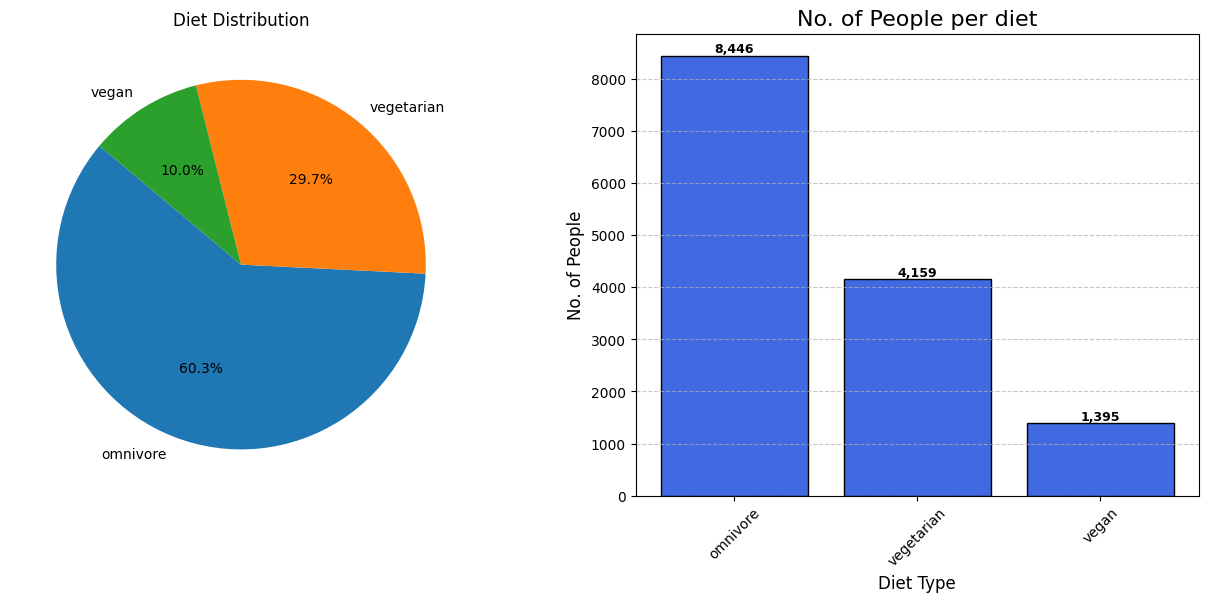

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(trainData.diet_type, title= 'Diet Distribution', ax=axes[0])
plot_bar(trainData.diet_type.value_counts().index, trainData.diet_type.value_counts().values, ax = axes[1], title='No. of People per diet', x_label= 'Diet Type', y_label='No. of People')

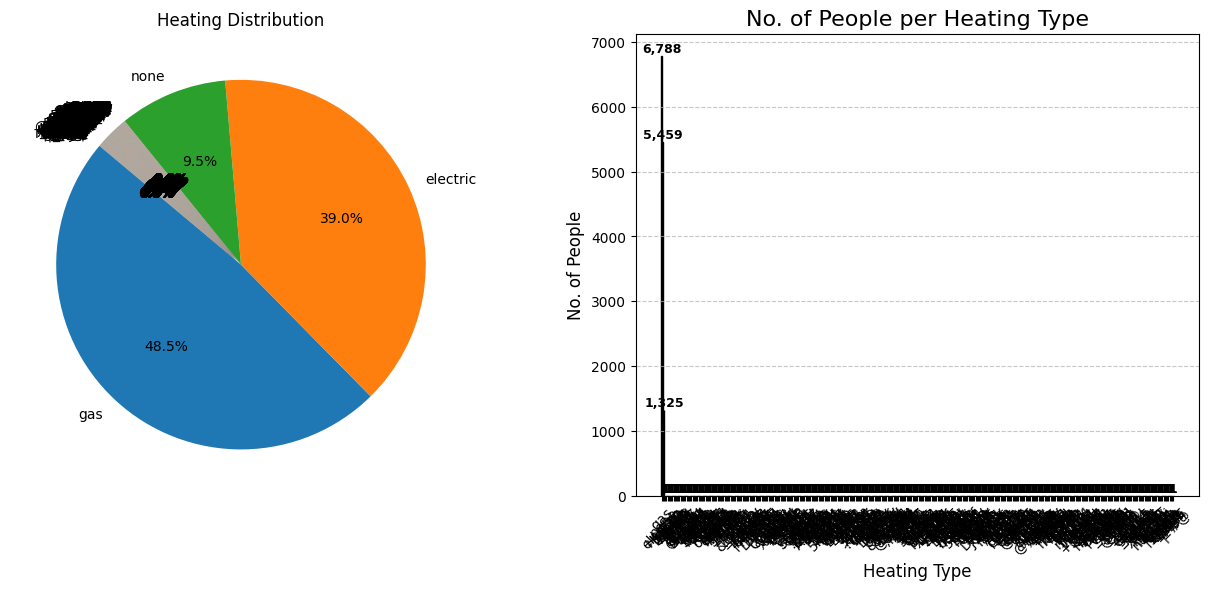

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(trainData.heating_type, title= 'Heating Distribution', ax=axes[0])
plot_bar(trainData.heating_type.value_counts().index, trainData.heating_type.value_counts().values, ax = axes[1], title='No. of People per Heating Type', x_label= 'Heating Type', y_label='No. of People')

Heating Type has a lot of Noise so better to drop it.

## **Data Preprocessing & Feature Engineering**

In [20]:
def convert_to_object(df):
    """Convert environmental behavior flags to 'yes'/'no' categorical strings."""
    df_in = df.copy()
    columns = [
        'recycles_regularly',
        'composts_organic_waste',
        'smart_thermostat_installed',
        'uses_solar_panels',
        'energy_efficient_appliances',
        'owns_pet'
    ]
    for col in columns:
        df_in[col] = df_in[col].apply(lambda x: 'yes' if x == 1.0 else ('no' if x == 0.0 else np.nan)).astype('object')
    return df_in

def convert_to_float(df):
    """Convert household_size and house_area_sqft to floats safely."""
    df_in = df.copy()
    df_in['house_area_sqft'] = pd.to_numeric(df_in['house_area_sqft'], errors='coerce')
    df_in['household_size'] = pd.to_numeric(df_in['household_size'], errors='coerce')
    return df_in

def drop_heating_type(df):
    """Drop the heating_type column."""
    df_in = df.copy()
    if 'heating_type' in df_in.columns:
        df_in = df_in.drop(columns=['heating_type'])
    return df_in

In [25]:
def calculate_total_resource_consumption(df):
    """Calculate total resource consumption per day and add a new column."""
    df_in = df.copy()
    df_in['electricity_per_day'] = df_in['electricity_kwh_per_month'] / 30
    df_in['natural_gas_per_day'] = df_in['natural_gas_therms_per_month'] / 30
    df_in['vehicle_miles_per_day'] = df_in['vehicle_miles_per_month'] / 30
    df_in['total_resource_per_day'] = (df_in['electricity_per_day'] + 
                                    df_in['natural_gas_per_day'] + 
                                    df_in['vehicle_miles_per_day'] + 
                                    df_in['water_usage_liters_per_day'])
    return df_in

def calculate_energy_efficiency(df):
    """Calculate a basic energy efficiency score and add a new column."""
    df_in = df.copy()
    df_in['energy_efficiency_score'] = (
        (df_in['home_insulation_quality'].fillna(0) / 5) +  
        df_in['energy_efficient_appliances'].fillna(0) + 
        df_in['smart_thermostat_installed'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0)
    ) / 4  
    return df_in

def calculate_resource_usage_per_person(df):
    """Calculate resource usage per person (electricity, water, vehicle, etc.)."""
    df_in = df.copy()
    df_in['electricity_per_person'] = df_in['electricity_kwh_per_month'] / df_in['household_size']
    df_in['water_per_person'] = df_in['water_usage_liters_per_day'] / df_in['household_size']
    df_in['vehicle_miles_per_person'] = df_in['vehicle_miles_per_month'] / df_in['household_size']
    return df_in

def calculate_sustainability_index(df):
    """Calculate sustainability index based on eco-friendly behaviors."""
    df_in = df.copy()
    df_in['sustainability_index'] = (
        df_in['recycles_regularly'].fillna(0) + 
        df_in['composts_organic_waste'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0) + 
        df_in['energy_efficient_appliances'].fillna(0) +
        df_in['diet_type'].apply(lambda x: 1 if x in ['vegan', 'vegetarian'] else 0)
    )
    return df_in

def calculate_renewable_adoption_flag(df):
    """Create a flag indicating renewable energy adoption (solar panels)."""
    df_in = df.copy()
    df_in['renewable_adoption_flag'] = (df_in['uses_solar_panels'] == 1) & (df_in['energy_efficient_appliances'] == 1)
    return df_in

def calculate_eco_consciousness_level(df):
    """Count the number of 'yes' responses for eco-friendly behaviors."""
    df_in = df.copy()
    df_in['eco_consciousness_level'] = (
        df_in['recycles_regularly'].fillna(0) + 
        df_in['composts_organic_waste'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0) + 
        df_in['energy_efficient_appliances'].fillna(0) + 
        df_in['smart_thermostat_installed'].fillna(0)
    )
    return df_in

def calculate_transport_impact(df):
    """Estimate environmental impact from personal and public transport."""
    df_in = df.copy()
    df_in['transport_impact_score'] = (
        df_in['vehicle_miles_per_month'] * 0.79 / 1000  
        - df_in['public_transport_usage_per_week'] * 4 * 0.105  
    )
    return df_in

In [26]:
X = trainData.copy().drop(columns=['carbon_footprint', 'ID'])
Y = trainData.carbon_footprint

In [27]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [51]:
feature_pipeline = Pipeline([
    ('drop_heating_type', FunctionTransformer(drop_heating_type)),
    ('convert_float', FunctionTransformer(convert_to_float)),
    ('add_energy_efficiency', FunctionTransformer(calculate_energy_efficiency)),
    ('add_resource_usage_per_person', FunctionTransformer(calculate_resource_usage_per_person)),
    ('add_sustainability_index', FunctionTransformer(calculate_sustainability_index)),
    ('add_total_resource_consumption', FunctionTransformer(calculate_total_resource_consumption)),
    ('add_eco_conscious_level', FunctionTransformer(calculate_eco_consciousness_level)),
    ('add_renewable_adoption_flag', FunctionTransformer(calculate_renewable_adoption_flag)),
    #('add_tranport_impact', FunctionTransformer(calculate_transport_impact)),
    ('convert_object', FunctionTransformer(convert_to_object))
]).set_output(transform='pandas')

In [52]:
Xfeatured = feature_pipeline.fit_transform(X)

In [53]:
Xfeatured

,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,...,electricity_per_person,water_per_person,vehicle_miles_per_person,sustainability_index,electricity_per_day,natural_gas_per_day,vehicle_miles_per_day,total_resource_per_day,eco_consciousness_level,renewable_adoption_flag
0,759.70,55.95,944.55,2422.07,541.27,1,3.0,2,4.23,9,...,253.233333,180.423333,314.850000,3.0,25.323333,1.865000,31.485000,599.943333,2.0,False
1,387.06,70.59,1280.85,1995.30,280.39,1,2.0,1,3.27,8,...,193.530000,140.195000,640.425000,1.0,12.902000,2.353000,42.695000,338.340000,0.0,False
2,594.25,29.14,1005.72,2673.55,416.14,0,2.0,3,2.87,3,...,297.125000,208.070000,502.860000,2.0,19.808333,0.971333,33.524000,470.443667,3.0,False
3,503.76,74.68,1049.46,2994.28,530.13,0,5.0,1,3.22,9,...,100.752000,106.026000,209.892000,1.0,16.792000,2.489333,34.982000,584.393333,1.0,False
4,549.54,0.00,756.49,2549.57,604.10,5,4.0,4,2.92,2,...,137.385000,151.025000,189.122500,3.0,18.318000,0.000000,25.216333,647.634333,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,324.96,43.37,438.36,1514.05,419.48,3,1.0,2,3.17,7,...,324.960000,419.480000,438.360000,0.0,10.832000,1.445667,14.612000,446.369667,1.0,False
13996,581.19,83.50,1865.29,3357.90,651.11,0,1.0,3,6.60,3,...,581.190000,651.110000,1865.290000,2.0,19.373000,2.783333,62.176333,735.442667,2.0,False
13997,302.76,43.36,212.42,939.08,343.67,9,1.0,2,3.07,3,...,302.760000,343.670000,212.420000,2.0,10.092000,1.445333,7.080667,362.288000,3.0,False
13998,397.77,14.80,592.66,1164.04,271.67,2,7.0,0,2.48,4,...,56.824286,38.810000,84.665714,3.0,13.259000,0.493333,19.755333,305.177667,2.0,False


In [54]:
categorical_columns = Xfeatured.select_dtypes(include=['object','category']).columns
numerical_columns = Xfeatured.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('categorical', categorical_transformer, categorical_columns)
], remainder='passthrough', sparse_threshold=0)

In [55]:
preprocessor_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [56]:
Xtransform = preprocessor_pipeline.fit_transform(Xfeatured)

In [57]:
Xtransform.shape

(14000, 36)

In [58]:
YNormalized = np.log(Y.values) - 6.5

In [59]:
x_train, x_val, y_train, y_val = train_test_split(Xtransform, YNormalized, test_size=0.2, random_state=42)

In [60]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(11200, 36)
(11200,)
(2800, 36)
(2800,)


## **Linear Regression**

In [61]:
linear = LinearRegression()

linear.fit(x_train, y_train)

LinearRegression()

In [62]:
val_predictions_lr = linear.predict(x_val)

print(mse(y_val, val_predictions_lr))
print(r2(y_val, val_predictions_lr))

0.007407154272371656
0.8841326063574859


In [63]:
testData = pd.read_csv(testPath)

In [64]:
testfeatured = feature_pipeline.transform(testData)
x_test = preprocessor_pipeline.transform(testfeatured)

In [99]:
predictions_linear = linear.predict(x_test)
predictions_linear = np.exp(predictions_linear + 6.5)
submission_linear = testData[['ID']].copy()

submission_linear['carbon_footprint'] = predictions_linear
submission_linear.to_csv(r'submissions\SubmissionLR.csv', index=False)

## **XGBoost**

In [65]:
xgb = XGBRegressor(tree_method='hist', objective='reg:squarederror', random_state=42, device='cuda')

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 7, 10],
    'learning_rate': [0.001,0.01, 0.05],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.1, 1],
    'reg_lambda': [0, 1]
}


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,  
    scoring='neg_mean_squared_error',
    cv=5)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=No...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.001, 0.01, 0.05],
                         'max_depth': [3, 7, 10], 'n_estimators': [100, 300],
                         'reg_alpha': [0.1, 1], 'reg_lambda': [0, 1]},
             scoring='neg_mean_squared_error')

In [66]:
print(grid_search.best_params_)

tuned_xgb = grid_search.best_estimator_

val_predictions_xgb = tuned_xgb.predict(x_val)

print(mse(y_val, val_predictions_xgb))
print(r2(y_val, val_predictions_xgb))

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1}
0.006527748293908976
0.8978888310736604


0.006345681108174742

0.9007368411870097

In [27]:
predictions_xgb = tuned_xgb.predict(x_test)
predictions_xgb = np.exp(predictions_xgb + 6.5)
submission_xgb = testData[['ID']].copy()

submission_xgb['carbon_footprint'] = predictions_xgb
submission_xgb.to_csv(r'submissions\SubmissionXGB.csv', index=False)

In [70]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',  
        'predictor': 'gpu_predictor',
        'n_estimators': trial.suggest_int('n_estimators', 50, 350),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-1, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    model = XGBRegressor(**param)
    model.fit(x_train, y_train)

    preds = model.predict(x_val)
    return mse(y_val, preds)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-05-02 17:19:53,655] A new study created in memory with name: no-name-94198a49-2448-46d6-8aa1-22b17890321c
[I 2025-05-02 17:19:54,198] Trial 0 finished with value: 0.06112125088047649 and parameters: {'n_estimators': 180, 'max_depth': 3, 'learning_rate': 0.00023684364384544854, 'colsample_bytree': 0.708614860246824, 'reg_alpha': 0.5580516329413413, 'reg_lambda': 0.1838037145723056}. Best is trial 0 with value: 0.06112125088047649.
[I 2025-05-02 17:19:54,729] Trial 1 finished with value: 0.006918709144625689 and parameters: {'n_estimators': 147, 'max_depth': 6, 'learning_rate': 0.04051540281826822, 'colsample_bytree': 0.792484868781287, 'reg_alpha': 0.6107968002614753, 'reg_lambda': 0.45604493936651247}. Best is trial 1 with value: 0.006918709144625689.
[I 2025-05-02 17:19:55,014] Trial 2 finished with value: 0.04100352468555396 and parameters: {'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.002660858008141496, 'colsample_bytree': 0.761482893437392, 'reg_alpha': 0.270562

Best params: {'n_estimators': 314, 'max_depth': 3, 'learning_rate': 0.12074709335992281, 'colsample_bytree': 0.8252956295785222, 'reg_alpha': 0.47770405216359535, 'reg_lambda': 0.24948363953130845}
Best RMSE: 0.006207825748931684


In [73]:
pramas = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist', 
        'device': 'cuda', 
        'predictor': 'gpu_predictor',
        'n_estimators': 314,
        'max_depth': 3, 
        'learning_rate': 0.12074709335992281, 
        'colsample_bytree': 0.8252956295785222, 
        'reg_alpha': 0.47770405216359535, 
        'reg_lambda': 0.24948363953130845}

optuna_xgb = XGBRegressor(**pramas)
optuna_xgb.fit(x_train, y_train)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8252956295785222, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12074709335992281,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=314, n_jobs=None,
             num_parallel_tree=None, ...)

In [74]:
val_predictions_xgb = optuna_xgb.predict(x_val)

print(mse(y_val, val_predictions_xgb))
print(r2(y_val, val_predictions_xgb))

0.006207825748931684
0.9028932619375163


In [75]:
predictions_xgb = optuna_xgb.predict(x_test)
predictions_xgb = np.exp(predictions_xgb + 6.5)
submission_xgb = testData[['ID']].copy()

submission_xgb['carbon_footprint'] = predictions_xgb
submission_xgb.to_csv(r'submissions\SubmissionXGBOptuna.csv', index=False)

## **NN**

In [28]:
print(x_train.dtype, y_train.dtype)

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

x_val = np.array(x_val).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)


train_tensor = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(256).prefetch(tf.data.AUTOTUNE)
val_tensor = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(256).prefetch(tf.data.AUTOTUNE)

float64 float64


In [34]:
def create_model(trial):
    model = tf.keras.Sequential()
    
    num_hidden = trial.suggest_int(f'n_units_l_1', 16, 768, step=16)
    model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    dropout_rate = trial.suggest_float(f'dropout_l', 0.0, 0.3)
    if dropout_rate > 0:
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    num_hidden = trial.suggest_int(f'n_units_l_2', 32, 128)
    model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(1))  

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='mse', optimizer=optimizer)
    return model


def objective(trial):
    model = create_model(trial)
    
    history = model.fit(
        train_tensor,
        validation_data=val_tensor,
        epochs=50,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    )

    y_pred = model.predict(x_val).flatten()
    return mse(y_val, y_pred)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value (MSE):", trial.value)
print("  Params:", trial.params)

[I 2025-04-29 15:17:02,846] A new study created in memory with name: no-name-b7d6293d-604d-461b-a6cb-38e9312acda8


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:17:07,424] Trial 0 finished with value: 0.00635635806247592 and parameters: {'n_units_l_1': 624, 'dropout_l': 0.19347243329001698, 'n_units_l_2': 45, 'lr': 0.0016289357145942646}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


[I 2025-04-29 15:17:11,141] Trial 1 finished with value: 0.006408791523426771 and parameters: {'n_units_l_1': 656, 'dropout_l': 0.0695451439343231, 'n_units_l_2': 39, 'lr': 0.007706834444320738}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:17:14,953] Trial 2 finished with value: 0.00689133582636714 and parameters: {'n_units_l_1': 560, 'dropout_l': 0.12340841787483009, 'n_units_l_2': 80, 'lr': 0.0020640322770978142}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


[I 2025-04-29 15:17:18,039] Trial 3 finished with value: 0.007346287369728088 and parameters: {'n_units_l_1': 320, 'dropout_l': 0.01473371438003319, 'n_units_l_2': 44, 'lr': 0.0013605969594564402}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


[I 2025-04-29 15:17:23,250] Trial 4 finished with value: 0.007748702075332403 and parameters: {'n_units_l_1': 80, 'dropout_l': 0.00824131606765458, 'n_units_l_2': 86, 'lr': 0.000313976679681682}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


[I 2025-04-29 15:17:26,292] Trial 5 finished with value: 0.006426967214792967 and parameters: {'n_units_l_1': 672, 'dropout_l': 0.15142557019609007, 'n_units_l_2': 54, 'lr': 0.0037978189494661625}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


[I 2025-04-29 15:17:30,344] Trial 6 finished with value: 0.007057213224470615 and parameters: {'n_units_l_1': 80, 'dropout_l': 0.25052846373102083, 'n_units_l_2': 50, 'lr': 0.0005965970023626752}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:17:35,573] Trial 7 finished with value: 0.007020648568868637 and parameters: {'n_units_l_1': 384, 'dropout_l': 0.09622686758876393, 'n_units_l_2': 41, 'lr': 0.008052590788863542}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


[I 2025-04-29 15:17:40,954] Trial 8 finished with value: 0.007901760749518871 and parameters: {'n_units_l_1': 96, 'dropout_l': 0.008662561565503324, 'n_units_l_2': 102, 'lr': 0.00024694432320711285}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:17:45,241] Trial 9 finished with value: 0.0068864645436406136 and parameters: {'n_units_l_1': 720, 'dropout_l': 0.2552377088021385, 'n_units_l_2': 33, 'lr': 0.006022764664991453}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:17:52,967] Trial 10 finished with value: 0.007717286702245474 and parameters: {'n_units_l_1': 496, 'dropout_l': 0.19941026433077833, 'n_units_l_2': 126, 'lr': 3.0220924229832314e-05}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:17:56,289] Trial 11 finished with value: 0.006728904787451029 and parameters: {'n_units_l_1': 768, 'dropout_l': 0.09101124802501036, 'n_units_l_2': 67, 'lr': 0.001195204270910689}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:18:04,230] Trial 12 finished with value: 0.00676028523594141 and parameters: {'n_units_l_1': 576, 'dropout_l': 0.20843324112604764, 'n_units_l_2': 65, 'lr': 9.748502335768744e-05}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:18:07,928] Trial 13 finished with value: 0.0063824462704360485 and parameters: {'n_units_l_1': 272, 'dropout_l': 0.29719762062152977, 'n_units_l_2': 32, 'lr': 0.0034282891793158575}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


[I 2025-04-29 15:18:12,727] Trial 14 finished with value: 0.006649491377174854 and parameters: {'n_units_l_1': 240, 'dropout_l': 0.28569040656689343, 'n_units_l_2': 62, 'lr': 0.002609301657420622}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


[I 2025-04-29 15:18:17,779] Trial 15 finished with value: 0.0065218801610171795 and parameters: {'n_units_l_1': 240, 'dropout_l': 0.1891634404125027, 'n_units_l_2': 32, 'lr': 0.0007108880088658718}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


[I 2025-04-29 15:18:25,328] Trial 16 finished with value: 0.011036684736609459 and parameters: {'n_units_l_1': 464, 'dropout_l': 0.2903364829364953, 'n_units_l_2': 82, 'lr': 1.002565817321891e-05}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


[I 2025-04-29 15:18:31,201] Trial 17 finished with value: 0.007280152291059494 and parameters: {'n_units_l_1': 256, 'dropout_l': 0.23928902739895203, 'n_units_l_2': 54, 'lr': 0.00013743948910359782}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


[I 2025-04-29 15:18:35,018] Trial 18 finished with value: 0.007079986855387688 and parameters: {'n_units_l_1': 160, 'dropout_l': 0.16374572707130547, 'n_units_l_2': 99, 'lr': 0.0007105187519294558}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:18:38,742] Trial 19 finished with value: 0.006483571138232946 and parameters: {'n_units_l_1': 384, 'dropout_l': 0.29660680735907247, 'n_units_l_2': 72, 'lr': 0.004665553247951043}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


[I 2025-04-29 15:18:42,789] Trial 20 finished with value: 0.006530285347253084 and parameters: {'n_units_l_1': 464, 'dropout_l': 0.22609011173744054, 'n_units_l_2': 46, 'lr': 0.0018747664268294112}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


[I 2025-04-29 15:18:45,133] Trial 21 finished with value: 0.06393025070428848 and parameters: {'n_units_l_1': 640, 'dropout_l': 0.05351345221515255, 'n_units_l_2': 39, 'lr': 0.009823812661776678}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


[I 2025-04-29 15:18:50,051] Trial 22 finished with value: 0.006925894878804684 and parameters: {'n_units_l_1': 608, 'dropout_l': 0.057785691610863776, 'n_units_l_2': 34, 'lr': 0.0038569954362701504}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


[I 2025-04-29 15:18:54,129] Trial 23 finished with value: 0.0064485399052500725 and parameters: {'n_units_l_1': 704, 'dropout_l': 0.17388010407374915, 'n_units_l_2': 56, 'lr': 0.0032236353648601285}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


[I 2025-04-29 15:18:58,529] Trial 24 finished with value: 0.00642855791375041 and parameters: {'n_units_l_1': 528, 'dropout_l': 0.12068612237220441, 'n_units_l_2': 42, 'lr': 0.009413733567633309}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:19:01,522] Trial 25 finished with value: 0.006871158257126808 and parameters: {'n_units_l_1': 768, 'dropout_l': 0.047880147829815214, 'n_units_l_2': 48, 'lr': 0.001180892235886534}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


[I 2025-04-29 15:19:04,942] Trial 26 finished with value: 0.006404264830052853 and parameters: {'n_units_l_1': 320, 'dropout_l': 0.12859356057646049, 'n_units_l_2': 37, 'lr': 0.006658708031380324}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


[I 2025-04-29 15:19:09,801] Trial 27 finished with value: 0.006988256238400936 and parameters: {'n_units_l_1': 304, 'dropout_l': 0.13110096579193564, 'n_units_l_2': 127, 'lr': 0.0005274735377550691}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


[I 2025-04-29 15:19:13,571] Trial 28 finished with value: 0.006482960190623999 and parameters: {'n_units_l_1': 192, 'dropout_l': 0.2716747101660264, 'n_units_l_2': 59, 'lr': 0.0022667286113390323}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


[I 2025-04-29 15:19:17,719] Trial 29 finished with value: 0.0063899802044034 and parameters: {'n_units_l_1': 320, 'dropout_l': 0.21534571266882546, 'n_units_l_2': 73, 'lr': 0.005225194905956327}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


[I 2025-04-29 15:19:21,518] Trial 30 finished with value: 0.006820298731327057 and parameters: {'n_units_l_1': 416, 'dropout_l': 0.21842401287452634, 'n_units_l_2': 95, 'lr': 0.001388662801359807}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


[I 2025-04-29 15:19:25,219] Trial 31 finished with value: 0.006400006823241711 and parameters: {'n_units_l_1': 320, 'dropout_l': 0.1827695473155132, 'n_units_l_2': 110, 'lr': 0.006178915185592679}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


[I 2025-04-29 15:19:28,475] Trial 32 finished with value: 0.006455712486058474 and parameters: {'n_units_l_1': 352, 'dropout_l': 0.18245952283578776, 'n_units_l_2': 91, 'lr': 0.005133370049652915}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


[I 2025-04-29 15:19:31,316] Trial 33 finished with value: 0.007648506201803684 and parameters: {'n_units_l_1': 160, 'dropout_l': 0.23237332385462253, 'n_units_l_2': 111, 'lr': 0.003020636900893374}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:19:34,864] Trial 34 finished with value: 0.006694635841995478 and parameters: {'n_units_l_1': 304, 'dropout_l': 0.15683349616323988, 'n_units_l_2': 119, 'lr': 0.0018031207781162779}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


[I 2025-04-29 15:19:38,516] Trial 35 finished with value: 0.006372020114213228 and parameters: {'n_units_l_1': 432, 'dropout_l': 0.2658822368998824, 'n_units_l_2': 72, 'lr': 0.005074977085910481}. Best is trial 0 with value: 0.00635635806247592.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:19:42,616] Trial 36 finished with value: 0.00634356215596199 and parameters: {'n_units_l_1': 416, 'dropout_l': 0.2692766351124277, 'n_units_l_2': 76, 'lr': 0.0039414547648810375}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:19:46,588] Trial 37 finished with value: 0.0064817024394869804 and parameters: {'n_units_l_1': 464, 'dropout_l': 0.2691544285747882, 'n_units_l_2': 77, 'lr': 0.0010815598248711928}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


[I 2025-04-29 15:19:52,715] Trial 38 finished with value: 0.006475752219557762 and parameters: {'n_units_l_1': 416, 'dropout_l': 0.2680261156397996, 'n_units_l_2': 87, 'lr': 0.0034730725394175803}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:19:59,727] Trial 39 finished with value: 0.006553265731781721 and parameters: {'n_units_l_1': 512, 'dropout_l': 0.24815735886988088, 'n_units_l_2': 70, 'lr': 0.00041399792450985874}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


[I 2025-04-29 15:20:04,086] Trial 40 finished with value: 0.0064172022975981236 and parameters: {'n_units_l_1': 560, 'dropout_l': 0.2998438418539115, 'n_units_l_2': 50, 'lr': 0.0018471516365073778}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


[I 2025-04-29 15:20:07,850] Trial 41 finished with value: 0.006471386179327965 and parameters: {'n_units_l_1': 352, 'dropout_l': 0.2564432198089186, 'n_units_l_2': 76, 'lr': 0.004493028676960748}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


[I 2025-04-29 15:20:10,075] Trial 42 finished with value: 0.014486148953437805 and parameters: {'n_units_l_1': 16, 'dropout_l': 0.2791000562480749, 'n_units_l_2': 80, 'lr': 0.007022087262996601}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


[I 2025-04-29 15:20:13,360] Trial 43 finished with value: 0.0067534721456468105 and parameters: {'n_units_l_1': 272, 'dropout_l': 0.2041031636721448, 'n_units_l_2': 73, 'lr': 0.0023318970313561094}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


[I 2025-04-29 15:20:16,574] Trial 44 finished with value: 0.006926710717380047 and parameters: {'n_units_l_1': 208, 'dropout_l': 0.24418052985061608, 'n_units_l_2': 63, 'lr': 0.004323451915576214}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


[I 2025-04-29 15:20:20,430] Trial 45 finished with value: 0.0064367190934717655 and parameters: {'n_units_l_1': 416, 'dropout_l': 0.22226270157289307, 'n_units_l_2': 84, 'lr': 0.0029594329655528023}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


[I 2025-04-29 15:20:25,906] Trial 46 finished with value: 0.006576561369001865 and parameters: {'n_units_l_1': 368, 'dropout_l': 0.2593093515740428, 'n_units_l_2': 68, 'lr': 0.0008751658341962102}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:20:29,256] Trial 47 finished with value: 0.006408415734767914 and parameters: {'n_units_l_1': 656, 'dropout_l': 0.21263106575194135, 'n_units_l_2': 89, 'lr': 0.007478347095501666}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-29 15:20:33,040] Trial 48 finished with value: 0.006496167741715908 and parameters: {'n_units_l_1': 448, 'dropout_l': 0.2846054273160779, 'n_units_l_2': 57, 'lr': 0.0014950185582610547}. Best is trial 36 with value: 0.00634356215596199.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


[I 2025-04-29 15:20:39,234] Trial 49 finished with value: 0.006639608647674322 and parameters: {'n_units_l_1': 272, 'dropout_l': 0.23773153256164017, 'n_units_l_2': 61, 'lr': 0.00022217825890134786}. Best is trial 36 with value: 0.00634356215596199.


Best trial:
  Value (MSE): 0.00634356215596199
  Params: {'n_units_l_1': 416, 'dropout_l': 0.2692766351124277, 'n_units_l_2': 76, 'lr': 0.0039414547648810375}


In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(416, activation='relu'),
    tf.keras.layers.Dropout(0.2692766351124277),
    tf.keras.layers.Dense(76, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0039414547648810375),
              metrics=['mse', 'r2_score'])

In [38]:
model.fit(train_tensor,
          validation_data=val_tensor,
          epochs=75,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0775 - mse: 0.0775 - r2_score: -0.2275 - val_loss: 0.0095 - val_mse: 0.0095 - val_r2_score: 0.8509
Epoch 2/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - mse: 0.0111 - r2_score: 0.8232 - val_loss: 0.0075 - val_mse: 0.0075 - val_r2_score: 0.8832
Epoch 3/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - mse: 0.0095 - r2_score: 0.8488 - val_loss: 0.0071 - val_mse: 0.0071 - val_r2_score: 0.8889
Epoch 4/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - mse: 0.0088 - r2_score: 0.8605 - val_loss: 0.0068 - val_mse: 0.0068 - val_r2_score: 0.8931
Epoch 5/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - mse: 0.0085 - r2_score: 0.8642 - val_loss: 0.0067 - val_mse: 0.0067 - val_r2_score: 0.8948
Epoch 6/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - mse: 0.0081 - r2_score: 0.8713 - val_loss: 0.0067 - val_mse: 0.0067 - val_r2_score: 0.8956
Epoch 7/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

In [39]:
predictions_NN = model.predict(x_test)
predictions_NN = np.exp(predictions_NN + 6.5)
submission_NN = testData[['ID']].copy()

submission_NN['carbon_footprint'] = predictions_NN
submission_NN.to_csv(r'submissions\SubmissionNN.csv', index=False)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


## **LightGBM**

In [42]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbosity': -1,
        'max_bin':255,
        'learning_rate': trial.suggest_float('learning_rate', 5e-3, 5e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 1024),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
    }
    
    model = LGBMRegressor(**param)
        
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = cross_val_score(
        model, 
        x_train, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=kf, 
        n_jobs=-1
    )
    
    return scores.mean()  

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=50, timeout=3600)  

print("Best params:", study.best_params)
print("Best neg-RMSE:", study.best_value)


[I 2025-04-29 15:52:25,729] A new study created in memory with name: no-name-c1d1d7e6-2eee-41f0-8427-e910bcfbe13b
[I 2025-04-29 15:52:39,708] Trial 0 finished with value: -0.008521675719307044 and parameters: {'learning_rate': 0.011498098609026312, 'num_leaves': 335, 'max_depth': 17, 'min_child_samples': 52, 'subsample': 0.6049810066345829, 'colsample_bytree': 0.7328672086226362, 'reg_alpha': 1.6265040259520818, 'reg_lambda': 0.010907384040681, 'min_split_gain': 0.18104012810098852, 'n_estimators': 545}. Best is trial 0 with value: -0.008521675719307044.
[I 2025-04-29 15:52:47,146] Trial 1 finished with value: -0.00834339198441905 and parameters: {'learning_rate': 0.026154292738965294, 'num_leaves': 167, 'max_depth': 9, 'min_child_samples': 114, 'subsample': 0.9843053451652268, 'colsample_bytree': 0.7761647716639983, 'reg_alpha': 2.321271735083118, 'reg_lambda': 0.0003641372913728885, 'min_split_gain': 0.14328903200877516, 'n_estimators': 607}. Best is trial 1 with value: -0.0083433919

Best params: {'learning_rate': 0.013703183524732475, 'num_leaves': 478, 'max_depth': 5, 'min_child_samples': 65, 'subsample': 0.9030028046910165, 'colsample_bytree': 0.8441750211150699, 'reg_alpha': 0.0006235771614481666, 'reg_lambda': 2.356990410488257, 'min_split_gain': 0.0023134737583343683, 'n_estimators': 892}
Best neg-RMSE: -0.007528414023510526


In [36]:
params = {'objective': 'regression', 'metric': 'rmse',
        'boosting_type': 'gbdt', 'device': 'gpu', 'learning_rate': 0.02767699081464663, 
        'num_leaves': 321, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.532809035931003, 
        'colsample_bytree': 0.5648932078407829, 'reg_alpha': 0.0006058367578122122, 
        'reg_lambda': 0.30779044602767924, 'min_split_gain': 0.03333917277137181, 'n_estimators': 492, 'max_bin':255}

modelLGM = LGBMRegressor(
    n_estimators=512,
    learning_rate=0.025,
    num_leaves=512,            
    max_depth=-1,
    subsample=0.7,
    colsample_bytree=0.7,
    max_bin=255,               
    objective='regression',
    random_state=42,
    device='gpu',
    boosting_type='gbdt',    
    gpu_use_dp=False,            
    tree_method='gpu_hist'       
)

In [37]:
modelLGM.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(100), log_evaluation(100)]
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.0908984	valid_0's l2: 0.00826252
[200]	valid_0's rmse: 0.0831773	valid_0's l2: 0.00691846
[300]	valid_0's rmse: 0.0823769	valid_0's l2: 0.00678595
[400]	valid_0's rmse: 0.0826329	valid_0's l2: 0.00682819
Early stopping, best iteration is:
[310]	valid_0's rmse: 0.0823686	valid_0's l2: 0.00678458


LGBMRegressor(colsample_bytree=0.7, device='gpu', gpu_use_dp=False,
              learning_rate=0.025, max_bin=255, n_estimators=512,
              num_leaves=512, objective='regression', random_state=42,
              subsample=0.7, tree_method='gpu_hist')

In [38]:
predictions_LGBM = modelLGM.predict(x_test)
predictions_LGBM = np.exp(predictions_LGBM + 6.5)
submission_LGBM = testData[['ID']].copy()

submission_LGBM['carbon_footprint'] = predictions_LGBM
submission_LGBM.to_csv(r'submissions\SubmissioLGBM.csv', index=False)

## **Blending**

In [39]:
class BlendingRegressor:
    def __init__(self):
        self.xgb_params = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 10, 'tree_method':'hist', 'device':'cuda'}
        self.base_models = [
            XGBRegressor(
                **self.xgb_params
            ),
            LGBMRegressor(
                n_estimators=512, learning_rate=0.025, num_leaves=512,            
                max_depth=-1, subsample=0.7, colsample_bytree=0.7, max_bin=255,               
                objective='regression', random_state=42, device='gpu',
                boosting_type='gbdt', gpu_use_dp=False, tree_method='gpu_hist'        
            ),
            CatBoostRegressor(
                task_type='GPU', verbose=0, iterations=500, depth=6, learning_rate=0.05
            ),
            MLPRegressor(hidden_layer_sizes=(64,), max_iter=500)
        ]

        self.meta_model = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.1)

    def fit(self, X, y):
        X_base, X_holdout, y_base, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

        self.fitted_base_models = []
        self.model_holdout_scores = []

        meta_features = []
        for model in self.base_models:
            clone_model = clone(model)
            clone_model.fit(X_base, y_base)
            preds = clone_model.predict(X_holdout)
            score = -np.mean((preds - y_holdout) ** 2)  

            meta_features.append(preds)
            self.fitted_base_models.append(clone_model)
            self.model_holdout_scores.append(score)

        errors = np.array([np.sqrt(np.mean((p - y_holdout) ** 2)) for p in meta_features]) 
        weights = np.exp(-errors) 
        weights = weights / np.sum(weights)

        print(f"Model blending weights based on holdout -MSE: {weights}")

        meta_X = np.column_stack(meta_features) * weights

        self.meta_model.fit(meta_X, y_holdout)
        print("Elite BlendingRegressor trained!")

    def predict(self, X):
        meta_features = []
        for model in self.fitted_base_models:
            preds = model.predict(X)
            meta_features.append(preds)

        meta_X = np.column_stack(meta_features)
        meta_X = meta_X * np.array(self.model_holdout_scores) / np.sum(self.model_holdout_scores)

        return self.meta_model.predict(meta_X)

In [40]:
blendRegressor = BlendingRegressor()
blendRegressor.fit(x_train, y_train)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [00:23:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Model blending weights based on holdout -MSE: [0.25096748 0.24968425 0.25136763 0.24798064]
Elite BlendingRegressor trained!


In [41]:
val_predictions_blend = blendRegressor.predict(x_val)

print(mse(y_val, val_predictions_blend))
print(r2(y_val, val_predictions_blend))

0.007042574757344122
0.8898355898013783


In [42]:
predictions_Blend = blendRegressor.predict(x_test)
predictions_Blend = np.exp(predictions_Blend + 6.5)
submission_Blend = testData[['ID']].copy()

submission_Blend['carbon_footprint'] = predictions_Blend
submission_Blend.to_csv(r'submissions\SubmissioBlend.csv', index=False)

## **Stacking**

In [50]:
class LayeredStackingRegressor:
    def __init__(self):
        self.layer1_models = [
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (32,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (16,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (32,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda')
        ]

        self.layer2_models = [
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            CatBoostRegressor(task_type="GPU", verbose=0),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1)
        ]
        
        self.layer3_models = [
            LinearRegression(),
            Ridge(),
            LinearRegression()
        ]

        self.final_model = XGBRegressor( tree_method='hist', device='cuda')

    def fit(self, X, y):
        n_splits = 3
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Layer 1
        self.layer1_out = np.zeros((X.shape[0], len(self.layer1_models)))
        for idx, model in enumerate(self.layer1_models):
            clone_model = clone(model) 
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(X):
                clone_model.fit(X[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(X[val_idx])
            self.layer1_out[:, idx] = oof_preds

            model.fit(X, y)  
            print(f"Completed {idx + 1} pass of Layer 1")

        # Layer 2
        self.layer2_out = np.zeros((X.shape[0], len(self.layer2_models)))
        for idx, model in enumerate(self.layer2_models):
            clone_model = clone(model)
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(self.layer1_out):
                clone_model.fit(self.layer1_out[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(self.layer1_out[val_idx])
            self.layer2_out[:, idx] = oof_preds

            model.fit(self.layer1_out, y)
            print(f"Completed {idx + 1} pass of Layer 2")

        # Layer 3
        self.layer3_out = np.zeros((X.shape[0], len(self.layer3_models)))
        for idx, model in enumerate(self.layer3_models):
            clone_model = clone(model)
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(self.layer2_out):
                clone_model.fit(self.layer2_out[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(self.layer2_out[val_idx])
            self.layer3_out[:, idx] = oof_preds

            model.fit(self.layer2_out, y)
            print(f"Completed {idx + 1} pass of Layer 3")

        # Final model
        self.final_model.fit(self.layer3_out, y)
        print("Finished Stack Regressor with Final Model.")

        return self.final_model

    def predict(self, X):
        layer1_preds = np.column_stack([
            model.predict(X) for model in self.layer1_models
        ])
        layer2_preds = np.column_stack([
            model.predict(layer1_preds) for model in self.layer2_models
        ])
        layer3_preds = np.column_stack([
            model.predict(layer2_preds) for model in self.layer3_models
        ])
        return self.final_model.predict(layer3_preds)
    
    def layer_out(self):
        return self.layer1_out, self.layer2_out, self.layer3_out

In [51]:
stackingRegressor = LayeredStackingRegressor()
stackingRegressor.fit(x_train, y_train)

Completed 1 pass of Layer 1
Completed 2 pass of Layer 1
Completed 3 pass of Layer 1
Completed 4 pass of Layer 1
Completed 5 pass of Layer 1
Completed 6 pass of Layer 1
Completed 7 pass of Layer 1
Completed 1 pass of Layer 2
Completed 2 pass of Layer 2
Completed 3 pass of Layer 2
Completed 4 pass of Layer 2
Completed 5 pass of Layer 2
Completed 1 pass of Layer 3
Completed 2 pass of Layer 3
Completed 3 pass of Layer 3
Finished Stack Regressor with Final Model.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [52]:
val_predictions_stack = stackingRegressor.predict(x_val)

print(mse(y_val, val_predictions_stack))
print(r2(y_val, val_predictions_stack))

0.0069299037072516455
0.8915980616540133


In [53]:
predictions_stack = stackingRegressor.predict(x_test)
predictions_stack = np.exp(predictions_stack + 6.5)
submission_stack = testData[['ID']].copy()

submission_stack['carbon_footprint'] = predictions_stack
submission_stack.to_csv(r'submissions\Submissiostack.csv', index=False)